# Tuning `supernest`
## Motivation

In the previous example, we showed how to use `supernest` to accelerate nested sampling with `poychord`. While we used a cosmological-like posterior as well as the relevant priors, we did not carry over many of the subtleties of how it is executed in reality: for example, most cosmological runs exploit the parameter speed hierarchy (citation), which opens up the question of how to deal with the extra switching parameters. 

To answer all of these questions we shall attempt as close-to-real as possible simulation of a cosmological likelihood (barring the likelihood itself, which involves expensive computation), and provide as much commentary on the inner workings of `supernest` as we can. 

As before we approximate the Cosmological likelihood with the following Gaussian.

In [1]:
import numpy as np
import pypolychord as pp
from pypolychord.settings import PolyChordSettings as Settings
try: 
    from mpi4py import MPI
except ImportError: 
    pass

bounds = np.array([[1.610000000000000098e+00, 3.910000000000000142e+00],
                  [8.000000000000000444e-01, 1.199999999999999956e+00],
                  [5.000000000000000000e-01, 1.000000000000000000e+01],
                  [5.000000000000000104e-03, 1.000000000000000056e-01],
                  [1.000000000000000021e-03, 9.899999999999999911e-01],
                  [1.000000000000000021e-02, 8.000000000000000444e-01],
                  [9.874342179098187788e-01, 1.012565782090074640e+00],
                  [9.966815810147492405e-01, 1.003718418985220850e+00],
                  [9.947828966565528397e-01, 1.001317103343419390e+00],
                  [0.000000000000000000e+00, 2.000000000000000000e+02],
                  [0.000000000000000000e+00, 1.000000000000000000e+00],
                  [0.000000000000000000e+00, 1.000000000000000000e+01],
                  [0.000000000000000000e+00, 1.000000000000000000e+01],
                  [-1.452625672144938207e+00, 1.865262567205973454e+01],
                  [5.473743278550617930e-01, 2.065262567205973454e+01],
                  [-1.922365910661598321e+01, 6.622365910625386221e+01],
                  [-8.626256721449379938e+00, 1.924262567205973369e+02],
                  [0.000000000000000000e+00, 4.000000000000000000e+02],
                  [0.000000000000000000e+00, 4.000000000000000000e+02],
                  [0.000000000000000000e+00, 4.000000000000000000e+02],
                  [0.000000000000000000e+00, 4.000000000000000000e+02],
                  [-8.110513911504371731e-02, 3.411051391132544075e-01],
                  [-5.094726209860886423e-02, 3.109472620970751833e-01],
                  [7.631844753477834420e-03, 9.123681552426879948e-01],
                  [-1.548945241972177478e-01, 5.688945241941503195e-01],
                  [2.376318447534777611e-01, 1.142368155242687866e+00],
                  [-7.762089314791336125e-01, 4.652208931456128127e+00]])

covs = np.array([[1.966721383534008152e-04, 1.291097180639769482e-05, 5.693634640132524955e-07, 4.772209314169435741e-07, -4.496445527830370466e-06, 9.322408552378461512e-05, 9.421926820888628024e-06, 1.100375630390723051e-07, -1.098063919659239207e-07, -1.867817278813608617e-03, 1.945019518484858000e-04, 6.804441695333571802e-04, -1.743706029095589251e-03, 2.398915556636300149e-04, -3.089237148441134921e-04, -5.392956974194408485e-04, 7.206579943931729288e-04, -1.219105224558518150e-02, -5.581079408533948932e-03, 1.605451063743458572e-03, 2.727571544902513984e-03, -3.428669328492376554e-07, -1.074672941406098990e-05, 2.691855891555073173e-05, -2.767183985449993394e-05, -6.780842674588625166e-06, -5.885254697216294113e-05],
[1.291097180639769482e-05, 1.646619200415262962e-05, 3.251409454103747561e-07, 2.351037355320484764e-07, -3.265160708277847847e-06, 1.051608630160547711e-05, 5.238145478971220357e-07, -7.830483872810841638e-08, -3.691676919904805889e-08, -4.526237932462026659e-03, 1.000651573526806882e-04, 1.037752466452946006e-03, -2.183417664263036934e-03, 4.339736477057560410e-04, -2.429515749210827043e-04, 2.522140505599966475e-05, 1.864920975989914484e-03, -2.326633346370382896e-02, -6.762315602791633962e-03, 1.522375198907859441e-03, 4.722214767389054831e-03, 1.032871594370772548e-06, -1.221960085134954433e-06, 2.156505154462474777e-06, -1.036483327940581134e-05, -2.530887514584974091e-06, -3.379545397452541575e-05],
[5.693634640132524955e-07, 3.251409454103748090e-07, 9.212063134025508672e-08, 1.391594070291645980e-08, -1.103773889562868708e-07, 3.398521719362489189e-07, 2.988093356204596245e-08, -1.175296458405411480e-09, 2.276360650511476777e-10, 1.190675157504390539e-05, 7.712246886929452717e-07, 8.980932920923246268e-06, 5.971290867749152273e-06, -1.211291723766537345e-05, -1.909875415343608647e-06, 1.521040668790288746e-05, 1.313398998048145482e-05, -1.315885065825533625e-05, -9.011906740515441096e-06, -4.213246579441229034e-06, -4.496327934757195308e-05, 9.839322191796502877e-08, -1.488372163507621807e-07, 2.237268644610322893e-07, -5.231558505380252313e-07, -1.867680018454237689e-07, -2.755337555428385298e-06],
[4.772209314169435741e-07, 2.351037355320484764e-07, 1.391594070291645980e-08, 2.138370469132431626e-08, -9.702091419030872694e-08, 2.832443139812360688e-07, 2.780208008759507390e-08, 2.313370806111571111e-09, -2.950566481868137484e-09, -8.319685402590344366e-05, 1.803533326643015055e-06, 2.366750017560818520e-05, -3.689887587005944813e-05, 4.562124638633241647e-07, -5.315582600298943303e-06, -7.424755493179785135e-06, 1.765352134807569805e-05, -3.681425798728743407e-04, -1.983589714813643347e-04, -3.970685391895357531e-05, 2.652409785256879630e-05, -5.504548860097016157e-09, -9.566731652538358121e-08, 8.564635138489097794e-08, -4.025187512797479860e-07, -3.965557936435896468e-07, -2.149066315403973080e-06],
[-4.496445527830370466e-06, -3.265160708277847847e-06, -1.103773889562868708e-07, -9.702091419030872694e-08, 1.394726093194898534e-06, -3.539881615427495510e-06, -3.222041129005219137e-07, 6.820826705841200924e-10, 6.721681405047986245e-09, 3.212639343141516167e-04, -1.010900979733260186e-05, -1.156905457228009587e-04, 1.367861681033519185e-04, -3.694192796769718161e-05, -9.458923329074373309e-06, -7.211793542452755166e-05, -2.358969645213257157e-04, 1.172960391457248145e-03, 7.801958492158110820e-04, 1.367284442040983864e-04, -6.281580653975107019e-05, -1.280212889557101244e-07, 6.155834172337794701e-07, -1.046442654964174835e-06, 3.151952562604682984e-06, 2.818507684540549871e-06, 1.621699678213876124e-05],
[9.322408552378461512e-05, 1.051608630160547711e-05, 3.398521719362489189e-07, 2.832443139812360688e-07, -3.539881615427495510e-06, 5.174358354337599676e-05, -6.763214558948368343e-07, -6.484161873093832848e-09, -6.627004843804738926e-08, -1.412686429908375845e-03, 8.931851597674787412e-05, 4.960959957007298740e-04, -7.038927105643225665e-04, 3.484188076856450608e-04, 1.440874771790599557e-04, 1.291113723894453478e-04, 1.204948422747068645e-04, -9.669835250422193287e-03, -4.424727434889327501e-03, -4.859972101987741874e-04, -9.160974330562882519e-04, -1.191762907092016560e-06, -5.374045918621352499e-06, 1.081118955355929632e-05, -1.551068787501753841e-05, -1.077163176236280554e-05, -5.801937006069450510e-05],
[9.421926820888628024e-06, 5.238145478971220357e-07, 2.988093356204596245e-08, 2.780208008759507060e-08, -3.222041129005219137e-07, -6.763214558948366225e-07, 5.738080818983084905e-06, -4.464847859453632237e-09, 2.057609648714881388e-08, 8.511505527609262859e-04, -4.182042724098740133e-07, -1.476501415903019365e-05, 3.209315780199772537e-05, -3.331212944677270689e-05, -3.177580151682985588e-05, -5.318062898810102654e-05, 6.156563269907370205e-04, 4.096002077241992813e-03, 6.729934378756035999e-04, 3.325787617666090337e-04, 8.406803629987186569e-04, 1.607414576635672175e-06, -5.238536311184828745e-07, 1.685268930713236191e-06, -1.605852877164131272e-06, 3.230037921639516876e-06, 9.082081047635827195e-06],
[1.100375630390723977e-07, -7.830483872810842962e-08, -1.175296458405411480e-09, 2.313370806111571111e-09, 6.820826705841156463e-10, -6.484161873093827885e-09, -4.464847859453633892e-09, 3.621666982806814726e-07, -3.161360770199298257e-09, -1.898702657908959621e-04, 5.022332905149753311e-06, 1.018777233848232073e-04, -5.341026495441321886e-05, 1.700174073989781955e-04, -1.655719645030528822e-04, -4.780391529900653946e-05, 1.533471611937319470e-05, 3.728900306741834026e-03, 6.063046674428599605e-05, 4.413044026216462025e-04, 4.420446841185639341e-04, -2.205053610047921029e-07, 1.858013102762251966e-07, -1.050953589286479956e-06, 3.927111439084014283e-07, 2.300727265601282869e-07, -6.642737431428886122e-07],
[-1.098063919659239207e-07, -3.691676919904806551e-08, 2.276360650511474968e-10, -2.950566481868137484e-09, 6.721681405047987072e-09, -6.627004843804737602e-08, 2.057609648714881719e-08, -3.161360770199298257e-09, 3.798737350394670459e-07, 7.369885725422161641e-04, -5.382249937701086093e-07, -6.268476530103274900e-05, 2.193591589265928382e-05, -7.164534598549866799e-06, -4.243457996389883292e-05, 3.509693310553832686e-04, 8.158505755085517473e-04, 6.699283585270914519e-04, 1.212755517485945871e-04, -3.798619276994231412e-04, -1.341747722790597895e-03, 3.691984348375064547e-07, 3.520776381241082947e-07, -9.574885326964743776e-07, 5.299412709755262113e-08, -6.938440073983949600e-07, -1.509095277965382509e-06],
[-1.867817278813608617e-03, -4.526237932462026659e-03, 1.190675157504390369e-05, -8.319685402590347076e-05, 3.212639343141517794e-04, -1.412686429908375195e-03, 8.511505527609262859e-04, -1.898702657908959621e-04, 7.369885725422161641e-04, 4.357939283026010457e+01, -3.993385768616282139e-01, -8.662110055490285232e-01, -9.671750900001084561e-02, 1.264477368515303513e-01, 3.625661276030578417e-01, -5.895129285665473340e+00, -3.278800653065740534e+01, 3.496912420422429335e+01, 1.396730553147615073e+00, -1.350917297427253772e+01, -5.391148592308444876e+01, 2.324301781600246735e-03, -7.607650246677970457e-04, -7.606297953993399613e-03, -4.475889826468014941e-03, -1.628101174201617221e-02, -1.848750358104554389e-02],
[1.945019518484857458e-04, 1.000651573526806882e-04, 7.712246886929454834e-07, 1.803533326643014843e-06, -1.010900979733260186e-05, 8.931851597674788767e-05, -4.182042724098737486e-07, 5.022332905149753311e-06, -5.382249937701078682e-07, -3.993385768616281029e-01, 8.188687061824509450e-02, -4.443911058934599950e-02, 5.705378358625180085e-02, -1.661373733705787462e-02, 8.426066760461991406e-03, 1.103793543236826075e-01, 1.459835521320510254e-01, -5.321540195038449994e-01, 9.198762391550533435e-01, 1.700534795559929035e+00, 6.322752261253254957e-01, -8.838957034972747234e-06, 7.177601354732843739e-06, 2.891640985404954367e-04, 5.126211580939318770e-05, 1.716466543108219843e-04, 2.689540312294867296e-04],
[6.804441695333570718e-04, 1.037752466452946006e-03, 8.980932920923247962e-06, 2.366750017560818181e-05, -1.156905457228009723e-04, 4.960959957007297656e-04, -1.476501415903019534e-05, 1.018777233848232073e-04, -6.268476530103274900e-05, -8.662110055490285232e-01, -4.443911058934599950e-02, 3.762919316386755586e+00, -2.634993419837281081e+00, -1.483990588523521059e-01, 1.907406345212608045e-01, 2.570856109168323744e+00, 3.249332552985600309e+00, -2.962582552712839146e+01, -3.363281788858595078e+00, 7.271602054925047298e+00, 5.098385743108022616e+00, -1.523249895452206265e-04, 7.197099082731390357e-05, -2.010158847804655643e-03, -6.875052871483932097e-04, -1.836423659266276558e-03, -1.848823364229354232e-03],
[-1.743706029095589468e-03, -2.183417664263036934e-03, 5.971290867749152273e-06, -3.689887587005944813e-05, 1.367861681033519456e-04, -7.038927105643222413e-04, 3.209315780199770504e-05, -5.341026495441321886e-05, 2.193591589265928382e-05, -9.671750900001091500e-02, 5.705378358625180779e-02, -2.634993419837281081e+00, 5.679557862989463857e+00, 9.143199113996765270e-02, -2.007272448864249326e-01, -2.054052966180166973e+00, -2.380365182714726302e+00, 1.355703892910758590e+01, -4.558561915819478116e+00, -1.107857927312379331e+01, -8.849906493064768398e+00, -5.576943673436581542e-05, -1.349701862889897581e-03, -2.195580061364635523e-03, 8.466148416809643820e-04, 2.309419913119539888e-04, -8.725613075377692054e-03],
[2.398915556636299878e-04, 4.339736477057559868e-04, -1.211291723766538022e-05, 4.562124638633246411e-07, -3.694192796769717483e-05, 3.484188076856450608e-04, -3.331212944677270689e-05, 1.700174073989781955e-04, -7.164534598549862564e-06, 1.264477368515302402e-01, -1.661373733705787462e-02, -1.483990588523521614e-01, 9.143199113996763883e-02, 3.273983407244523303e+00, 5.160261285458043190e-01, 8.256891217781005265e-02, 6.130289452553309287e-02, -6.924559719467036523e+00, -7.368163288386213594e-01, -9.615791185156141729e-01, -6.292273545350594022e-01, -1.184497554319528714e-03, 1.102280476734968095e-03, 1.454538666631042046e-03, 9.088341969189153843e-04, -1.123612299170086452e-03, 2.002462445246404516e-04],
[-3.089237148441134921e-04, -2.429515749210827043e-04, -1.909875415343610341e-06, -5.315582600298943303e-06, -9.458923329074358063e-06, 1.440874771790599286e-04, -3.177580151682988298e-05, -1.655719645030528551e-04, -4.243457996389883970e-05, 3.625661276030578417e-01, 8.426066760461986202e-03, 1.907406345212608045e-01, -2.007272448864249326e-01, 5.160261285458043190e-01, 3.026862130276679608e+00, 2.657774486946730796e+00, 2.772620305766725135e+00, 5.098704955303388964e+00, -1.516625671193053915e+00, -7.553748613689448277e-01, -1.132047426602389661e+00, 1.182801512493591002e-03, 3.967829202259631760e-04, -2.133582355837178052e-03, 1.101972598682867278e-03, -5.625899253442973383e-04, -4.260286753622296793e-03],
[-5.392956974194411737e-04, 2.522140505599967830e-05, 1.521040668790288069e-05, -7.424755493179787676e-06, -7.211793542452752455e-05, 1.291113723894452665e-04, -5.318062898810099265e-05, -4.780391529900655302e-05, 3.509693310553832686e-04, -5.895129285665473340e+00, 1.103793543236826075e-01, 2.570856109168323300e+00, -2.054052966180166528e+00, 8.256891217781003878e-02, 2.657774486946730796e+00, 1.066177165440864094e+01, 1.911141143255897035e+01, -1.135080882017628312e+01, 3.350315802078033478e+00, 4.813553467363862026e+00, 5.430250613433121210e+00, 2.354396674934930347e-03, 8.724463910390375509e-04, -6.011352576925157142e-03, 1.085844900113334217e-03, -3.939466709795290227e-03, -6.266942311232840887e-03],
[7.206579943931724951e-04, 1.864920975989914050e-03, 1.313398998048144296e-05, 1.765352134807570143e-05, -2.358969645213256615e-04, 1.204948422747068238e-04, 6.156563269907368036e-04, 1.533471611937318454e-05, 8.158505755085517473e-04, -3.278800653065740534e+01, 1.459835521320510532e-01, 3.249332552985601197e+00, -2.380365182714726302e+00, 6.130289452553309981e-02, 2.772620305766725135e+00, 1.911141143255897035e+01, 5.290568818107959714e+01, -2.340637868769283614e+01, 4.209946281512855215e+00, 8.366712117364954793e+00, 3.285203423535507028e+01, 3.122314447459043074e-03, 2.296532918716110566e-03, -5.118189291562067443e-03, 4.751380698990131761e-03, 1.834103294506422410e-03, 3.026106007641412004e-03],
[-1.219105224558518150e-02, -2.326633346370382896e-02, -1.315885065825538199e-05, -3.681425798728743949e-04, 1.172960391457248362e-03, -9.669835250422195022e-03, 4.096002077241992813e-03, 3.728900306741834460e-03, 6.699283585270914519e-04, 3.496912420422429335e+01, -5.321540195038448884e-01, -2.962582552712839146e+01, 1.355703892910758412e+01, -6.924559719467034746e+00, 5.098704955303388964e+00, -1.135080882017628490e+01, -2.340637868769283259e+01, 7.633105794533947801e+02, 6.835148189228210924e+01, -5.350275352763002701e+01, -5.820395859405653738e+01, 7.288104157505832272e-03, 1.960362879560536599e-03, -1.996992257909149110e-02, 2.080952017320863295e-02, 3.003308625585691949e-02, 4.264706540068673862e-02],
[-5.581079408533949800e-03, -6.762315602791633962e-03, -9.011906740515441096e-06, -1.983589714813643347e-04, 7.801958492158111904e-04, -4.424727434889326634e-03, 6.729934378756035999e-04, 6.063046674428600283e-05, 1.212755517485945600e-04, 1.396730553147614406e+00, 9.198762391550533435e-01, -3.363281788858595966e+00, -4.558561915819478116e+00, -7.368163288386213594e-01, -1.516625671193054137e+00, 3.350315802078033034e+00, 4.209946281512855215e+00, 6.835148189228210924e+01, 6.070264188872054945e+01, 3.953473357132260446e+01, 1.477572753846344433e+01, 2.012894622103961976e-03, 3.799714994846200254e-03, 7.234883459982933800e-03, 7.662232651801734705e-03, 2.107893710769592061e-03, 4.232630277668522623e-02],
[1.605451063743457921e-03, 1.522375198907859441e-03, -4.213246579441234116e-06, -3.970685391895356175e-05, 1.367284442040983864e-04, -4.859972101987741332e-04, 3.325787617666091421e-04, 4.413044026216462025e-04, -3.798619276994231412e-04, -1.350917297427253772e+01, 1.700534795559929035e+00, 7.271602054925047298e+00, -1.107857927312379331e+01, -9.615791185156141729e-01, -7.553748613689448277e-01, 4.813553467363862026e+00, 8.366712117364954793e+00, -5.350275352763002701e+01, 3.953473357132260446e+01, 8.367488892786619203e+01, 5.188502773152066538e+01, -8.385299496210154159e-05, 3.326080524959812521e-03, 1.452176489884526162e-02, 6.835917937804938255e-03, 8.511968525758001336e-03, 4.613777534168961997e-02],
[2.727571544902513984e-03, 4.722214767389054831e-03, -4.496327934757193275e-05, 2.652409785256878953e-05, -6.281580653975115151e-05, -9.160974330562885772e-04, 8.406803629987185484e-04, 4.420446841185638256e-04, -1.341747722790597895e-03, -5.391148592308445586e+01, 6.322752261253254957e-01, 5.098385743108021728e+00, -8.849906493064768398e+00, -6.292273545350594022e-01, -1.132047426602390106e+00, 5.430250613433119433e+00, 3.285203423535508449e+01, -5.820395859405655159e+01, 1.477572753846344611e+01, 5.188502773152066538e+01, 1.010387715768648746e+02, -3.369603625186983007e-03, 4.137856688726865989e-03, 1.888634459951864936e-02, 1.061657594524114193e-02, 2.680038174450754054e-02, 6.216729984875647014e-02],
[-3.428669328492349554e-07, 1.032871594370773607e-06, 9.839322191796494936e-08, -5.504548860096996305e-09, -1.280212889557100185e-07, -1.191762907092016772e-06, 1.607414576635672175e-06, -2.205053610047920500e-07, 3.691984348375065606e-07, 2.324301781600247602e-03, -8.838957034972806526e-06, -1.523249895452207891e-04, -5.576943673436590351e-05, -1.184497554319528930e-03, 1.182801512493590569e-03, 2.354396674934929913e-03, 3.122314447459043074e-03, 7.288104157505832272e-03, 2.012894622103961976e-03, -8.385299496210296460e-05, -3.369603625186982573e-03, 1.452523459004919845e-03, 2.745648315342531657e-04, 9.198999719962998908e-05, -3.707806022892612408e-04, -1.367811966734843734e-04, -6.419406905204716365e-05],
[-1.074672941406098820e-05, -1.221960085134954009e-06, -1.488372163507621542e-07, -9.566731652538358121e-08, 6.155834172337794701e-07, -5.374045918621353346e-06, -5.238536311184830862e-07, 1.858013102762252231e-07, 3.520776381241082947e-07, -7.607650246677967205e-04, 7.177601354732821716e-06, 7.197099082731378160e-05, -1.349701862889897581e-03, 1.102280476734968312e-03, 3.967829202259630134e-04, 8.724463910390378761e-04, 2.296532918716111434e-03, 1.960362879560534431e-03, 3.799714994846201122e-03, 3.326080524959812955e-03, 4.137856688726866856e-03, 2.745648315342531114e-04, 8.577114733436835186e-04, 8.799473869932706097e-05, 7.422308326713782187e-04, 7.697987304472291015e-05, -6.341445431869911602e-04],
[2.691855891555073173e-05, 2.156505154462475624e-06, 2.237268644610322893e-07, 8.564635138489095147e-08, -1.046442654964174835e-06, 1.081118955355929293e-05, 1.685268930713236826e-06, -1.050953589286479956e-06, -9.574885326964743776e-07, -7.606297953993402215e-03, 2.891640985404953282e-04, -2.010158847804656944e-03, -2.195580061364634655e-03, 1.454538666631040745e-03, -2.133582355837177185e-03, -6.011352576925155407e-03, -5.118189291562068310e-03, -1.996992257909149110e-02, 7.234883459982931198e-03, 1.452176489884525988e-02, 1.888634459951865283e-02, 9.198999719962996197e-05, 8.799473869932706097e-05, 7.205381457996519468e-03, -2.730586675311162800e-04, 6.746539188062741126e-04, 4.641937114490112329e-03],
[-2.767183985449992717e-05, -1.036483327940581134e-05, -5.231558505380251254e-07, -4.025187512797479860e-07, 3.151952562604682137e-06, -1.551068787501753841e-05, -1.605852877164130001e-06, 3.927111439084015871e-07, 5.299412709755255496e-08, -4.475889826468014074e-03, 5.126211580939311993e-05, -6.875052871483934265e-04, 8.466148416809641652e-04, 9.088341969189150590e-04, 1.101972598682867278e-03, 1.085844900113333567e-03, 4.751380698990130894e-03, 2.080952017320862948e-02, 7.662232651801737307e-03, 6.835917937804941724e-03, 1.061657594524114366e-02, -3.707806022892612408e-04, 7.422308326713782187e-04, -2.730586675311163342e-04, 2.879804587096969695e-03, 5.643084471821309704e-04, -9.144100090822661299e-04],
[-6.780842674588627707e-06, -2.530887514584974091e-06, -1.867680018454237689e-07, -3.965557936435898056e-07, 2.818507684540549448e-06, -1.077163176236280554e-05, 3.230037921639516876e-06, 2.300727265601285780e-07, -6.938440073983950659e-07, -1.628101174201617221e-02, 1.716466543108219843e-04, -1.836423659266275691e-03, 2.309419913119535280e-04, -1.123612299170086669e-03, -5.625899253442975551e-04, -3.939466709795288492e-03, 1.834103294506421976e-03, 3.003308625585692990e-02, 2.107893710769589892e-03, 8.511968525758003071e-03, 2.680038174450754748e-02, -1.367811966734843192e-04, 7.697987304472292370e-05, 6.746539188062742210e-04, 5.643084471821308620e-04, 6.422389861656077788e-03, 7.976067387275968118e-03],
[-5.885254697216293435e-05, -3.379545397452541575e-05, -2.755337555428385722e-06, -2.149066315403973504e-06, 1.621699678213876463e-05, -5.801937006069450510e-05, 9.082081047635827195e-06, -6.642737431428889298e-07, -1.509095277965381661e-06, -1.848750358104554736e-02, 2.689540312294865128e-04, -1.848823364229354883e-03, -8.725613075377693789e-03, 2.002462445246420779e-04, -4.260286753622292456e-03, -6.266942311232838285e-03, 3.026106007641418509e-03, 4.264706540068675250e-02, 4.232630277668522623e-02, 4.613777534168961997e-02, 6.216729984875647708e-02, -6.419406905204717720e-05, -6.341445431869911602e-04, 4.641937114490112329e-03, -9.144100090822661299e-04, 7.976067387275968118e-03, 7.178986534461673230e-02]])


means  = np.array([3.044216694712165161e+00,
9.650855758442943300e-01,
1.040924144831850029e+00,
2.237283121732486224e-02,
1.200560651155456460e-01,
5.410301296354644296e-02,
1.000634474760722314e+00,
9.996787729141320966e-01,
9.981818020437438488e-01,
4.678440579185234327e+01,
5.244381951336937187e-01,
5.479402746454355544e+00,
3.268370700471646462e+00,
8.920107392228670662e+00,
1.091392531032157187e+01,
1.865309777799564728e+01,
9.375259342019231212e+01,
2.585815407864638473e+02,
4.590609762313613373e+01,
4.226589856534864253e+01,
1.150610766831279932e+02,
1.140319089380447543e-01,
1.349241126954108805e-01,
4.812167446020677031e-01,
2.250448376583276677e-01,
6.657249956786769340e-01,
2.083381582310556812e+00])


def generate_model(bounds, means, covs):
    thetamin, thetamax = bounds[:,0], bounds[:,1]
    invCov = np.linalg.inv(covs)

    def prior(cube):
        return thetamin + cube * (thetamax - thetamin)

    def log_likelihood(theta):
        return (-(theta - means) @ invCov @ (theta - means) / 2.0 , [])

    return prior, log_likelihood

control = generate_model(bounds, means, covs)

settings = Settings(len(means), 0, file_root="tuned_control")
output = {} 
samples = {}

This time around, however, we shall add the speed hierarchy to the run. 

While this technique is used to accelerate nested sampling in real cases, for a simple correlated Gaussian such as ours it is unlikely to improve performance (particularly because the multivariate normal distributions are all highly-correlated). 

The numbers are taken from [this issue](https://github.com/PolyChord/PolyChordLite/issues/68), 

In [2]:
grade_dims = [6, 1, 20]
grade_frac = [12, 30, 600]

Which means that there are parameter blocks of $6$, $1$ and $20$ (the concordance model, and calibrtion parameters), each of which has a speed of $12$, $30$ and $600$ repeats. This has to do with how PolyChord's slice sampling can exploit the speed hierarchy of the likelihood.  

In [3]:
settings.grade_frac = grade_frac
settings.grade_dims = grade_dims

Crucially: 

In [4]:
len(grade_frac) == len(grade_dims) and sum(grade_dims) == len(means)

True

In [34]:
output["control"] = pp.run_polychord(control[1], len(means), 0, settings, prior=control[0])

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     675
nDims    :      27
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/tuned_control.resume

Resuming from previous run
number of repeats:           12          30         600
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =        55893                              |
| log(Z) =          -79.26889 +/-            0.31165 |
|____________________________________________________|


Note that in the previous example we used much fewer live points. While for illustration purposes, $n_{live} = 100$  was sufficient, in a realistic scenario one needs at least $n_\text{dims} \cdot 24$ live points, which is approximately $6$ times more than we used previously. 

## Adjustments to `supernest`

We compared the results of using `supernest` with the exact same settings, barring adjustments to the `nDims` variable, to what one would use with a regular uniform prior. 

However, both the precision and accuracy attainable with supernest is far in excess of a fair comparison to what can be obtained with a uniform prior. So it is not unreasonable to want to sacrifice some of the precision gains for an *even faster* run-time performance. 

There are three methods for trading precision for performance: 
1) $n_\text{live}$.  

2) `precision_criterion`.  

3) Reducing the number of repeats per slice. Can adversely impact the accuracy of the evidence more than the posterior. 

1) is the most straightforward. Reduction affects posterior more than the evidence. Performance inversely proportional to $n_\text{live}$, which means that for a $6 \times$ speedup one needs $6 \times$ fewer live points. 

2) Impacts the evidence and the posterior equally. Recall that on a Higson plot, when an accurate proposal is used, less time is spent discovering the bulk of the posterior mass, but *more* time is spent reaching the termination criterion. Thus tuning this parameter is likely to yield the most return. 

3) If proposals were a **consistent re-partitioning** of the original model, the evidence and the posterior should be invariant with respect to variations of the switching parameters (the final two). 

This means that regardless of how much we adjust the number of repetitions of the final two parameters, the resulting evidence should still be reliable. As a result, we can safely set the final two parameters to be the slowest in the speed hierarchy. **However, this is not conclusively optimal**: for some proposals, the frequent re-evaluations of the likelihood may be beneficial in finding the posterior mass.

In [6]:
import supernest as sn

proposal = sn.gaussian_proposal(bounds.T, means, covs, loglike=control[1])
proposal = sn.superimpose([control, proposal], nDims=len(means))

Here we must change the parameter blocking. We've added one proposal, meaning that the number of dimensions is increased by $n_\text{proposal} + 1 = 1+1$

In [7]:
proposal.nDims - len(means)

2

In [8]:
grade_dims = [6, 1, 20, 2]
grade_frac = [12, 30, 600, 2]

**note**: any integer $f \leq 1$ is not be interpreted as a speed, but as a directive to measure the speed. For  the switching parameter the measurement would make it  *fastest* rather than *slowest* parameters in the speed hierarchy. 

In [9]:
super_settings = Settings(
    proposal.nDims, 
    0, 
    grade_dims=grade_dims, 
    grade_frac=grade_frac, 
    file_root="tuned_super", 
    precision_criterion = 0.01, # 10 times more than normal
    nlive=100, # 6 times less
    read_resume=False
)

(super_settings.grade_dims, super_settings.grade_frac)

([6, 1, 20, 2], [12, 30, 600, 2])

In [24]:
output["proposal"] = pp.run_polychord(proposal.likelihood, proposal.nDims, 0, super_settings, prior=proposal.prior)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     100
nDims    :      29
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/tuned_super.resume

generating live points


all live points generated

number of repeats:           12          30         600           2
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =          186                              |
| log(Z) =          -79.35692 +/-            0.09235 |
|____________________________________________________|
Warning, unable to proceed after    101: failed spawn events


What we see is that the live points are spawned and the algorithm terminates immediately. This happens in our example because the likelihood is effectively flat.  

Unfortunately, because Anesthetic doesn't gracefully handle empty `live_birth` files, one ought to delete the empty file

In [29]:
!rm "chains/tuned_control_phys_live-birth.txt"
!rm "chains/tuned_super_phys_live-birth.txt"

rm: cannot remove 'chains/tuned_control_phys_live-birth.txt': No such file or directory


## Accuracy

In [30]:
logZ_expected = len(means)*np.log(2*np.pi)/2 + np.linalg.slogdet(covs)[1]/2 - np.sum(np.log(bounds[:, 1] - bounds[:,0])); logZ_expected

-78.48697718107633

Compare that to $\log \mathcal{Z}_\text{control} = -79.3 \pm 0.3$  and $\log \mathcal{Z}_\text{proposal} = -79.25 \pm   0.08$, which we obtain from the inferences. 

We can see that the evidence estimates are both reasonable, and within margin of error of each other. 

In [31]:
from anesthetic import NestedSamples

samples = {}
samples["control"] = NestedSamples(root="chains/tuned_control")
samples["proposal"] = NestedSamples(root="chains/tuned_super")

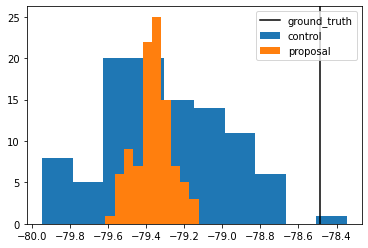

In [32]:
import matplotlib.pyplot as plt

plt.hist(samples["control"].logZ(100), label="control")
plt.axvline(logZ_expected, color="k", label="ground_truth")
plt.hist(samples["proposal"].logZ(100), label="proposal")
plt.legend()

As before, we can see that the control and the proposal are not quite able to find the correct evidence, both outside the respective confidence regions.  However, the "proposal" evidence estimate, while less accurate, is still acceptable. 

## Performance

The time required to obtain the acceptable estimate is significantly shorter. In the previous case we saw that just adding the proposal can result in a $O(20)$ speedup. We reduced the number of live points by a factor of $6$, so we expect a performance uplift $O(100)$, compared to traditional nested sampling. 

In reality the change to the precision criterion and the parameter hierarchy compound, and thus we can expect an uplift of $O(300)$ with some variance. This does not mean that the aggressive optimisation techniques we are using here were not previously possible, but that the tuning required for `supernest` is different to the tuning used with plain uniform priors. 

In [36]:
output["control"].nlike / output["proposal"].nlike

510.9240506329114

In terms of the number of dead points, this is a little less impressive. 

In [37]:
output["control"].ndead / output["proposal"].ndead

300.5

Nonetheless, we are still getting improved precision without a loss of accuracy, with much better performance. Further investigation into the tuning should be made to find the optimal parameter values.